In [1]:
from typing import List, Tuple
import pandas as pd
import requests
from io import StringIO
import re
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns

import pytest



def download_stats():
    f1 = "https://www.stat.gouv.qc.ca/statistiques/population-demographie/deces-mortalite/DecesSemaine_QC_2010-2020_GrAge.csv"

    req = requests.get(f1)
    csv = req.text
    df = pd.read_table(StringIO(csv), skiprows=5, sep=";", thousands=" ")

    # Remove comment line #1 and comments at end of file
    df = df[1:45]

    df.iloc[:,3:] = df.iloc[:,3:].replace(" ", "", regex=True).astype(float)
    df = df.drop("Statut", 1)

    return df

In [2]:
df= download_stats()
# df

In [3]:
# pd.set_option("display.max_columns", 100)
# df

In [4]:
# Population stats de https://www.stat.gouv.qc.ca/statistiques/population-demographie

population = pd.DataFrame([7929222, 8005090, 8061101, 8110880, 8150183, 8175272, 8225950, 8298827, 8387632, 8484965],
                          index=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
current_population = 8484965
# population

In [5]:
def get_grouping_by_age(groupe_age):
    df = download_stats()
    g = df[df["Groupe d'âge"] == groupe_age]
    g = g.transpose()
    g.drop("Groupe d'âge", inplace=True)
    g.columns = g.iloc[0]
    g = g[1:53]
    return g

In [6]:
age_total = get_grouping_by_age("Total")
age_70_plus = get_grouping_by_age("70 ans et plus")
age_50_69 = get_grouping_by_age("50-69 ans")
age_0_49 = get_grouping_by_age("0-49 ans")

SEASON_START_WEEK = 44
SEASON_END_WEEK = 22


In [7]:
def add_5_years_mean(df, col_name, new_col_name):

    def mean_past_years_per_week(year, span=5):
        for w in range(1, 52+1):
            week_code = f"{year}-{w:02}"

            sum = 0
            for k in range(1, span+1):
                val = df.loc[df.week_code == f"{year-k}-{w:02}", col_name].item()
                sum += val

                df.loc[df.week_code == week_code, new_col_name] = sum / span

    # Recent years, use 5 years for averaging
    for y in range(2015, 2020+1):
        mean_past_years_per_week(y, span=5)

    # We don't have older years, so us less years for averaging those
    mean_past_years_per_week(2014, span=4)
    mean_past_years_per_week(2013, span=3)
    mean_past_years_per_week(2012, span=2)
    mean_past_years_per_week(2011, span=1)
    df.loc[:52, new_col_name] = df.loc[:52, col_name].mean()

    # Test
    for i in range(1, SEASON_END_WEEK+1):
        assert (df.loc[df.week_code == f"2015-{i:02}", col_name].item() +
                df.loc[df.week_code == f"2016-{i:02}", col_name].item() +
                df.loc[df.week_code == f"2017-{i:02}", col_name].item() +
                df.loc[df.week_code == f"2018-{i:02}", col_name].item() +
                df.loc[df.week_code == f"2019-{i:02}", col_name].item() ) / 5 \
               == pytest.approx(df.loc[df.week_code == f"2020-{i:02}", new_col_name].item()), f"Error at i={i}"

# def add_rolling_mean(df, col_name, new_col_name, window):
#     df[new_col_name] = df.loc[:, col_name].rolling(window=window).mean()
#     # df[new_col_name] = df[new_col_name].shift(-window // 2)
#
# def add_mean(df, col_name, new_col_name):
#     df[new_col_name] = df.loc[:, col_name].mean()

# def add_constant(df, new_col_name, value):
#     df[new_col_name] = value

In [8]:
def create_df(values, rolling_window=52):
    s = []
    w = []
    d = []

    for i in range(2010, 2020+1):
        yd = values[f"{i}"].array
        s.extend([f"{i}"] + [f"{x}" if (x % 13==0) and x<52 else "" for x in range(1, len(yd))])
        w.extend([f"{i}-{w+1:02}" for w in range(len(yd))])
        d.extend(yd)

    df = pd.DataFrame({"semaine_label" : s, "week_code" : w, "deces" : d})

    for i in range(2010, 2020):
        df.loc[df.week_code == f"{i}-01", "population"] = population.iloc[i-2010].item()
    df.loc[df.week_code == "2020-52", "population"] = population.iloc[-1].item()
    
    # Add normalized population column
    df["population"] = df["population"].interpolate()
    df["deces_norm"] = df.deces * current_population / df["population"]

    # add mean column
    add_5_years_mean(df, "deces", "av")
    add_5_years_mean(df, "deces_norm", "av_norm")
    
    from scipy.ndimage.filters import gaussian_filter1d
    df["deces_smoothed"] = gaussian_filter1d(df["deces"], sigma=1)
    df["deces_norm_smoothed"] = gaussian_filter1d(df["deces_norm"], sigma=1)
    df["av_smoothed"] = gaussian_filter1d(df["av"], sigma=2)
    df["av_norm_smoothed"] = gaussian_filter1d(df["av_norm"], sigma=2)


    #
    # if mean_type == "rolling":
    #     add_rolling_mean(df, "deces", "av", rolling_window)
    #     add_rolling_mean(df, "deces_norm", "av_norm", rolling_window)
    # elif mean_type == "global":
    #     add_mean(df, "deces", "av")
    #     add_mean(df, "deces_norm", "av_norm")

    # Extend the missing, up to the season limit
    value = df.loc[rolling_window-1, "av"].item()
    value_norm = df.loc[rolling_window-1, "av_norm"].item()
    df.loc[:rolling_window, "av"] = value
    df.loc[:rolling_window, "av_norm"] = value_norm

    # Diff 
    df["diff_deces"] = (df["deces"] - df["av"])
    df["diff_deces_norm"] = (df["deces_norm"] - df["av_norm"])

    return df

In [9]:
df_total = create_df(age_total)
df_70_plus = create_df(age_70_plus)
df_50_69 = create_df(age_50_69)
df_0_49 = create_df(age_0_49)

In [10]:
def integrate_seasons(df, col, start_year=2011):

    season_totals = {}
    
    for i in range(start_year, 2020+1):
        left = f"{i-1}-{SEASON_START_WEEK}"
        right = f"{i}-{SEASON_END_WEEK}"

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item()
        season_totals[i] = df.loc[i1:i2, col].sum()
        

    return season_totals

def integrate_seasons_before_new_year(df, col, start_year=2011):

    season_totals = {}
    
    for i in range(start_year, 2020+1):
        left = f"{i-1}-{SEASON_START_WEEK}"
        right = f"{i-1}-52"

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item()
        season_totals[i] = df.loc[i1:i2, col].sum()

    return season_totals

def integrate_year(df, col, start_year=2011):

    season_totals = {}
    
    for i in range(start_year, 2020):
        left = f"{i}-01"
        right = f"{i}-52"

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item()
        season_totals[i] = df.loc[i1:i2, col].sum()

    return season_totals

In [11]:
def draw_seasons(df, ax, col_deces, col_av52, col_diff_deces, start_year=2011):
    for i in range(start_year, 2020+1):
        left = f"{i-1}-{SEASON_START_WEEK}"
        right = f"{i}-{SEASON_END_WEEK}"

        plt.axvline(x=f"{i}-01", c="grey", alpha=0.10)
        plt.axvspan(xmin=left, xmax=right, color="tab:gray", alpha=0.1)

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item() + 1
        
#         # Fill from 0 to average
#         ax.fill_between(df["week_code"][i1:i2], 0, df[col_av52][i1:i2], 
#                         facecolor='tab:blue', alpha=0.2)
        
        # Fill from average to top
        ax.fill_between(df["week_code"][i1:i2], df[col_av52][i1:i2], df[col_deces][i1:i2], 
                        where=df[col_diff_deces][i1:i2] > 0, interpolate=True, facecolor='tab:red', alpha=0.5)

        
        # Fill from average to top
        ax.fill_between(df["week_code"][i1:i2], df[col_av52][i1:i2], df[col_deces][i1:i2], 
                        where=df[col_diff_deces][i1:i2] < 0, interpolate=True, facecolor='tab:green', alpha=0.5)
        
#         print(i)
#         print(df[col_av52][i1:i2])
#         print(df[col_deces][i1:i2])
        

In [12]:
def draw_barplot(df, group_title, start_year=2011):
    group_title = group_title + f" ({start_year}-2020)"
    
    season_totals = integrate_seasons(df, col="deces_norm", start_year=start_year)

    start_row = df_total.index[df_total['week_code'] == f"{start_year}-01"].item()
    df = df.iloc[start_row:]
    df.reset_index(drop=True, inplace=True)

    st = pd.DataFrame({"annee":list(season_totals.keys()), "deces": list(season_totals.values())})
    st.columns = ["annee", "deces"]
    # st.index.name = "annee"
    # st = st.transpose()
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.subplots_adjust(top=0.8)

    g = sns.barplot(x="annee", y="deces", data=st, palette="Blues_d", ax=ax)
    
    for index, row in st.iterrows():
        g.text(x=row.name, y=(int(row.deces) * 0.95), s=int(row.deces), color='white', va="center", ha="center",fontsize="x-large")

    group_title_formatted = group_title.replace(" ", "\ ")
    plt.title(f"Décès au Québec $\\bf{{toutes\ causes\ confondues}}$\npar saison grippale\n[de novembre à mai (semaines CDC {SEASON_START_WEEK} à {SEASON_END_WEEK})]\n"
              f"$\\bf{{ {group_title_formatted} }}$",
              fontsize="xx-large")

    fig.text(0.90, 0.0, 'github.com/yanickc', fontsize=20, color='gray', ha='right', va='bottom', alpha=0.5)

    plt.show()

    fig.savefig(f"images/bar_graph_{group_title.replace(' ', '_')}.png",pad_inches=0.5)


In [13]:
def draw_lineplot(df, group_title, col_deces, col_av, col_diff_deces, start_year=2010, start_month=1, bottom_y=0, top_y = 2300, annotations=True, seasons_annotations=True):
    group_title = group_title + f" ({start_year}-2020)"
    
    start_row = df_total.index[df_total['week_code'] == f"{start_year}-{start_month:02}"].item()
    df = df.iloc[start_row:]
    df.reset_index(drop=True, inplace=True)

    fig, ax = plt.subplots(figsize=(20, 10))
    
    inv = ax.transData 

    plt.subplots_adjust(top=0.7)

    g = sns.lineplot(x="week_code", y=col_deces, data=df, label="Décès par semaine", color="tab:blue")

    # truncate the average to the existing data length
    i1 = df.index[df['week_code'] == f"2020-{SEASON_END_WEEK}"].item()
#     sns.lineplot(x="week_code", ci=None,  y=col_av, data=df.iloc[:i1+1], label=f"Moyenne de la semaine des 5 années précédentes", color="black")
    sns.lineplot(x="week_code", ci=None,  y=col_av+"_smoothed", data=df.iloc[:i1+1], label=f"Moyenne de la semaine des 5 années précédentes", color="dimgray")
    ax.lines[1].set_linestyle("--")

    g.set_xticklabels(df["semaine_label"])

    ax.set(xlabel="Semaines", ylabel="Decès", title="")

    # Close last point of smoothed curve to same
    df_draw = df.copy()
    df_draw.loc[df_draw.week_code == f"2020-{SEASON_END_WEEK}", col_deces] = df_draw.loc[df_draw.week_code == f"2020-{SEASON_END_WEEK}", col_av+"_smoothed"]
    draw_seasons(df_draw, ax, col_deces, col_av+"_smoothed", col_diff_deces, start_year=start_year + 1)

    # Title
    group_title_formatted = group_title.replace(" ", "\ ")
    plt.text((2020-start_year)/2*52, top_y*1.1, f"Décès par semaine au Québec, $\\bf{{toutes\ causes\ confondues}}$\n$\\bf{{ {group_title_formatted} }}$", fontsize="xx-large", ha="center")

    # Totals whole year header
    plt.text(0, bottom_y+(top_y-bottom_y)*0.05, "Total pour l'année:", fontsize="large", ha="left", color="grey")
    year_totals = integrate_year(df, col_deces, start_year=start_year+1)
    for i, v in enumerate(year_totals.values()):
        plt.text((i+1) * 52 + 26 - start_month, bottom_y+(top_y-bottom_y)*0.05, int(v), fontsize="large", ha="center", color="grey")
        plt.annotate("", xytext = ((i+1) * 52-start_month, bottom_y+(top_y-bottom_y)*0.04), xy = ((i+1) * 52 + 52-start_month, bottom_y+(top_y-bottom_y)*0.04), color="grey ", arrowprops = {"facecolor" : "grey", "arrowstyle": "<|-|>"})
    
    # Totals header
    plt.text(10, top_y*1.07, "Total par saison grippale:", fontsize="large", ha="right", color="tab:blue")
    season_totals = integrate_seasons(df, col_deces, start_year=start_year+1)
    for i, v in enumerate(season_totals.values()):
        plt.text((i+1) * 52 + 7 - start_month, top_y*1.07, f"{v:.0f}", fontsize="large", ha="center", color="tab:blue")
    
    # Excess header
    plt.text(10, top_y*1.06, "Excès p/r à la moyenne:", fontsize="large", ha="right", va="top", color="tab:red")
    season_totals_diff_over_mean = integrate_seasons(df, col_diff_deces, start_year=start_year+1)
    for i, v in enumerate(season_totals_diff_over_mean.values()):
        plt.text((i+1) * 52 + 7 - start_month, top_y*1.06, f"{v:.0f}\n({(int(v)/season_totals[start_year+1+i]) * 100:2.1f}%)", fontsize="large", ha="center", va="top", color="tab:red")
    
    
    if annotations:
        # Lockdown date
        plt.axvline(x="2020-12", c="red", alpha=0.25)
        plt.annotate("Début du confinement au Québec (16 mars 2020)",
            ha = "right", va = "bottom",
            xytext = ("2019-36", top_y*0.90), xy = ("2020-12", top_y*0.90),
            arrowprops = {"facecolor" : "black", "arrowstyle": "-|>", "connectionstyle": "angle,angleA=0,angleB=-33,rad=10"})

        # Flu season arrow
        plt.text("2020-07", top_y*0.94, "Saison\ngrippale", ha="center")
        plt.annotate("", xytext = (f"2019-{SEASON_START_WEEK}", top_y*0.93),xy = (f"2020-{SEASON_END_WEEK}", top_y*0.93), arrowprops = {"facecolor" : "black", "arrowstyle": "<|-|>"})

        
    if seasons_annotations:
        # First part of 2020 season
        season_totals_diff_over_mean_before_new_year = integrate_seasons_before_new_year(df, col_diff_deces, start_year=start_year+1)
        plt.annotate(f"Excès p/r moyenne\npremière partie 2020\n$\\bf{{{season_totals_diff_over_mean_before_new_year[2020]:.0f}}}$",
            ha = "center", va = "bottom",
            xytext = ("2019-28", 1800), xy = ("2020-01", 1500),
            arrowprops = {"facecolor" : "black", "arrowstyle": "-|>", "connectionstyle": "angle,angleA=0,angleB=-67,rad=10"})
        # 2019
        plt.annotate(f"Excès p/r moyenne\nsaison 2019\n$\\bf{{{season_totals_diff_over_mean[2019]:.0f}}}$",
            ha = "center", va = "bottom",
            xytext = ("2018-36", 1650), xy = ("2019-01", 1500),
            arrowprops = {"facecolor" : "black", "arrowstyle": "-|>", "connectionstyle": "angle,angleA=0,angleB=-67,rad=10"})
        from matplotlib.patches import Ellipse
        ellipse = Ellipse(xy=("2019-25", 1450), width=90, height=295, 
                        edgecolor='gray', linestyle='--', fc='None', lw=1)
        ax.add_patch(ellipse)

        if start_year <= 2014:
            ellipse = Ellipse(xy=("2016-35", 1450), width=100, height=295, 
                            edgecolor='gray', linestyle='--', fc='None', lw=1)
            ax.add_patch(ellipse)

    plt.xticks(rotation=90)
    ax.set_ylim([bottom_y, top_y])

    fig.text(0.90, 0.0, 'github.com/yanickc', fontsize=20, color='gray', ha='right', va='bottom', alpha=0.5)
    plt.legend(loc=2)
    plt.show()

    fig.savefig(f"images/line_graph_{group_title.replace(' ', '_')}.png")



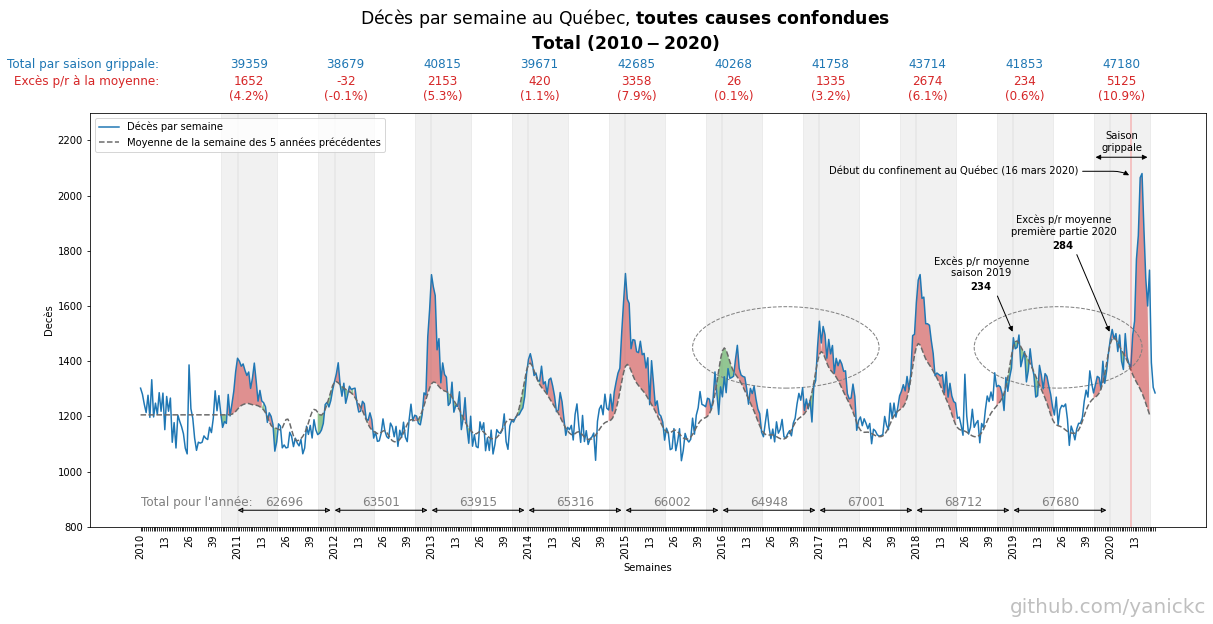

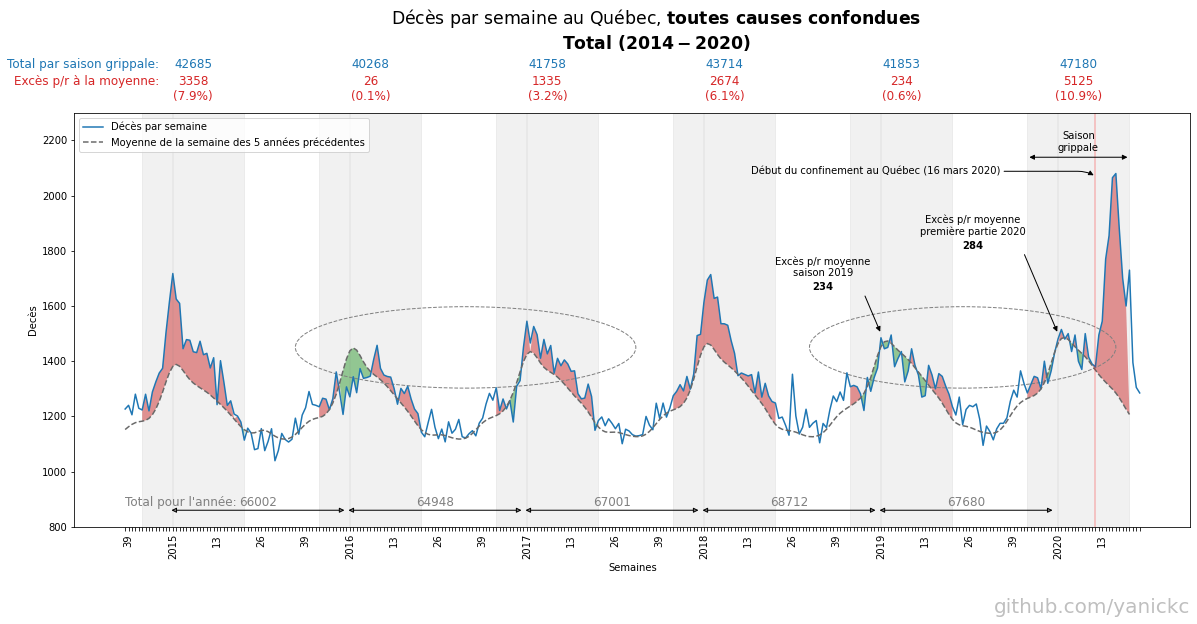

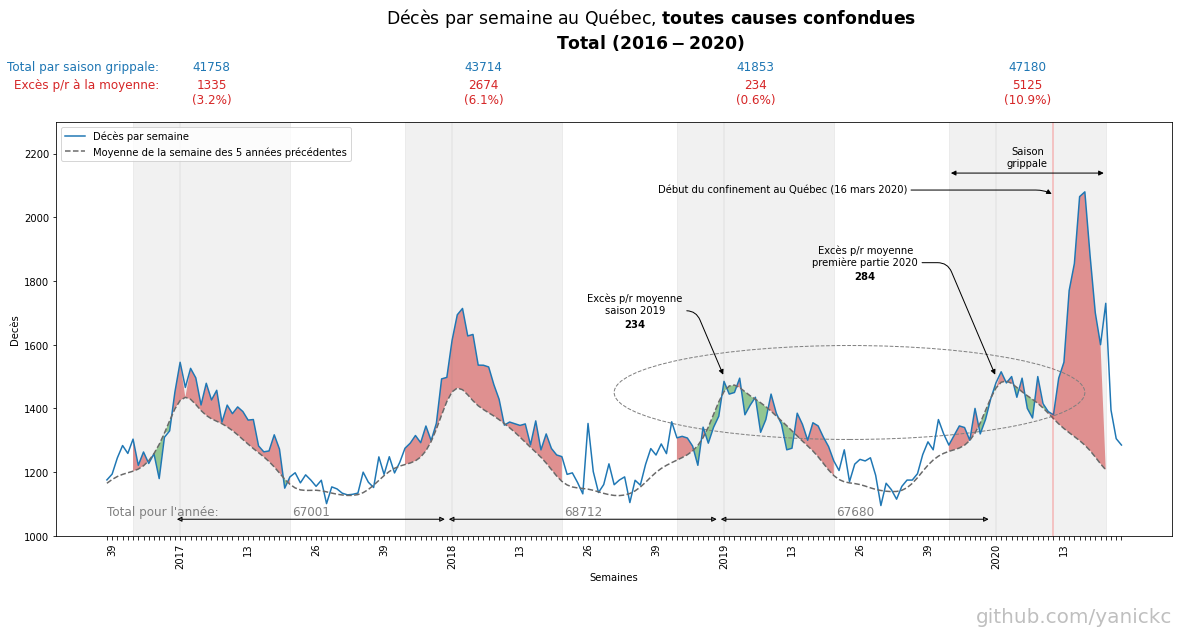

In [14]:
draw_lineplot(df_total, "Total", "deces_norm", "av_norm", "diff_deces_norm", bottom_y=800, top_y=2300)
draw_lineplot(df_total, "Total", "deces_norm", "av_norm", "diff_deces_norm", bottom_y=800, top_y=2300, start_year=2014, start_month=39)
draw_lineplot(df_total, "Total", "deces_norm", "av_norm", "diff_deces_norm", bottom_y=1000, top_y=2300, start_year=2016, start_month=39)

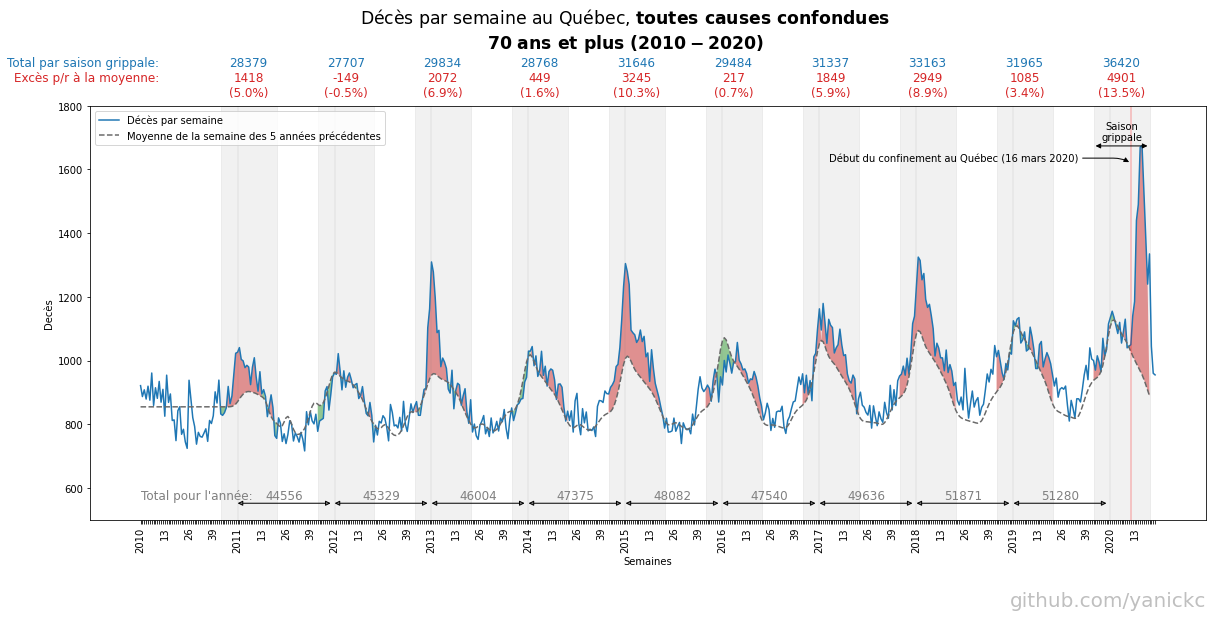

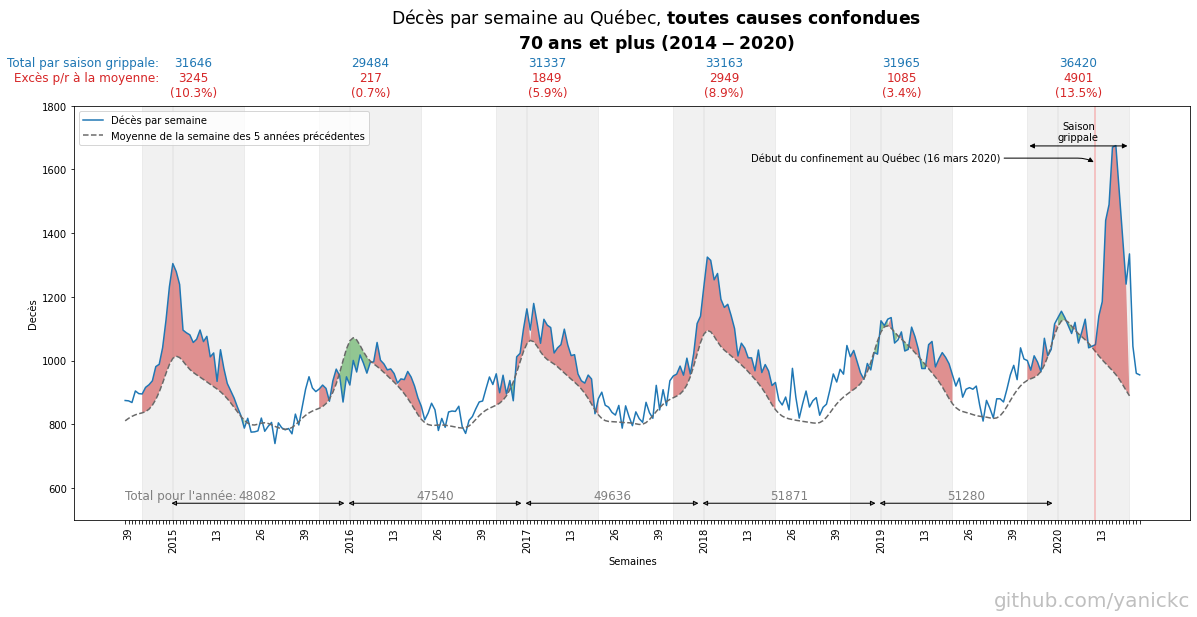

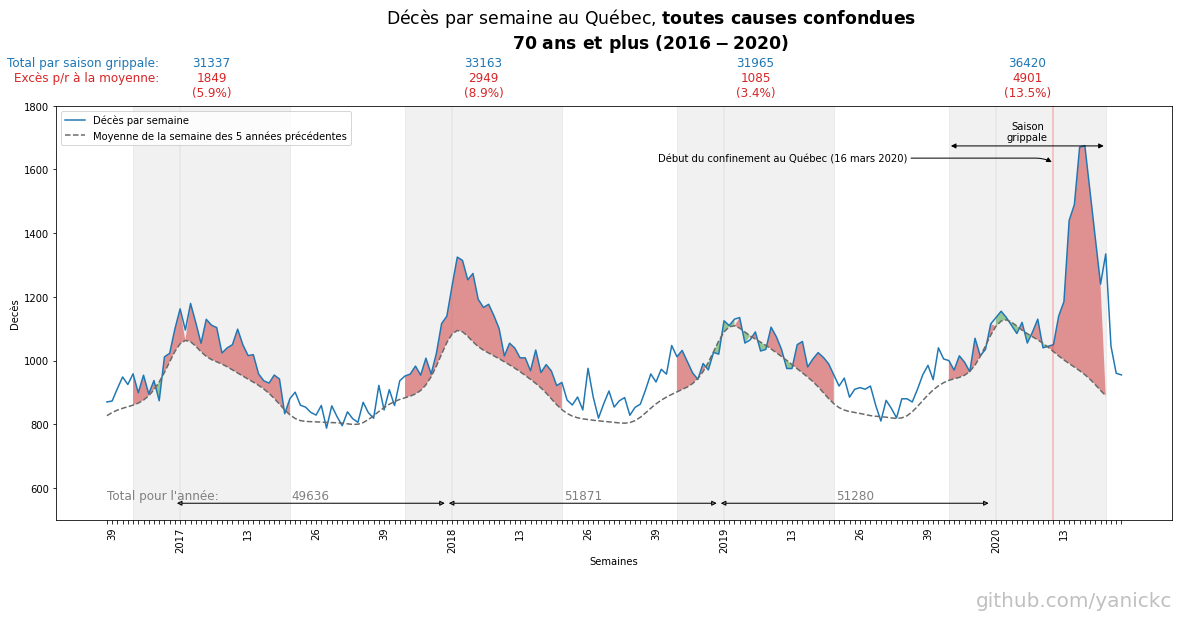

In [15]:
draw_lineplot(df_70_plus, "70 ans et plus", "deces_norm", "av_norm", "diff_deces_norm", bottom_y=500, top_y=1800, seasons_annotations=False)
draw_lineplot(df_70_plus, "70 ans et plus", "deces_norm", "av_norm", "diff_deces_norm", bottom_y=500, top_y=1800, start_year=2014, start_month=39, seasons_annotations=False)
draw_lineplot(df_70_plus, "70 ans et plus", "deces_norm", "av_norm", "diff_deces_norm", bottom_y=500, top_y=1800, start_year=2016, start_month=39, seasons_annotations=False)

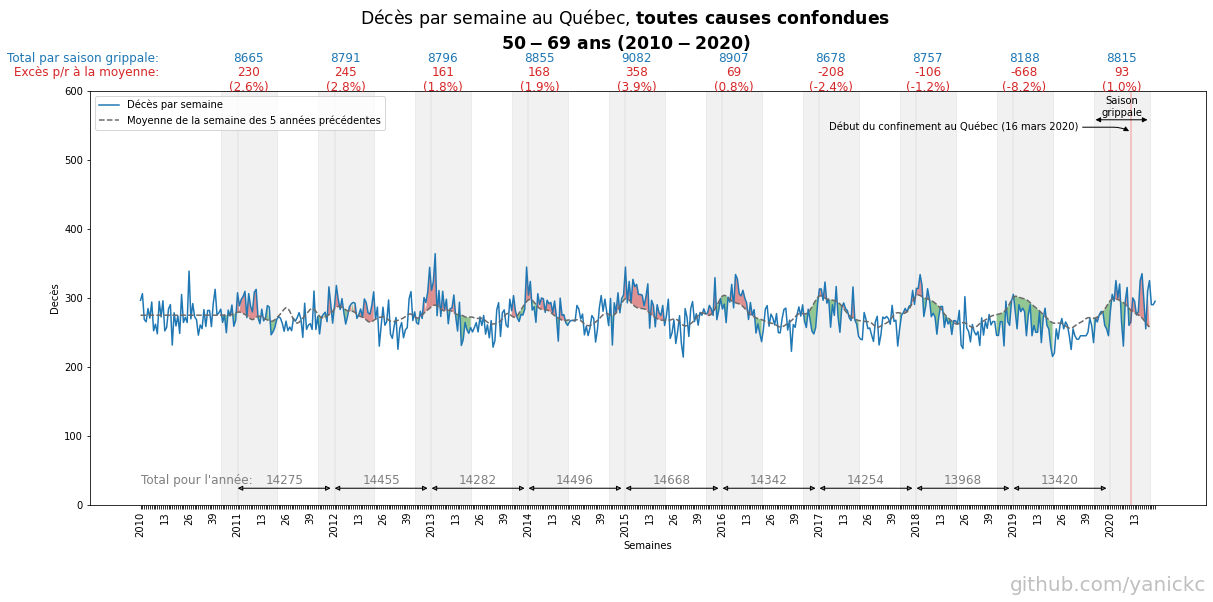

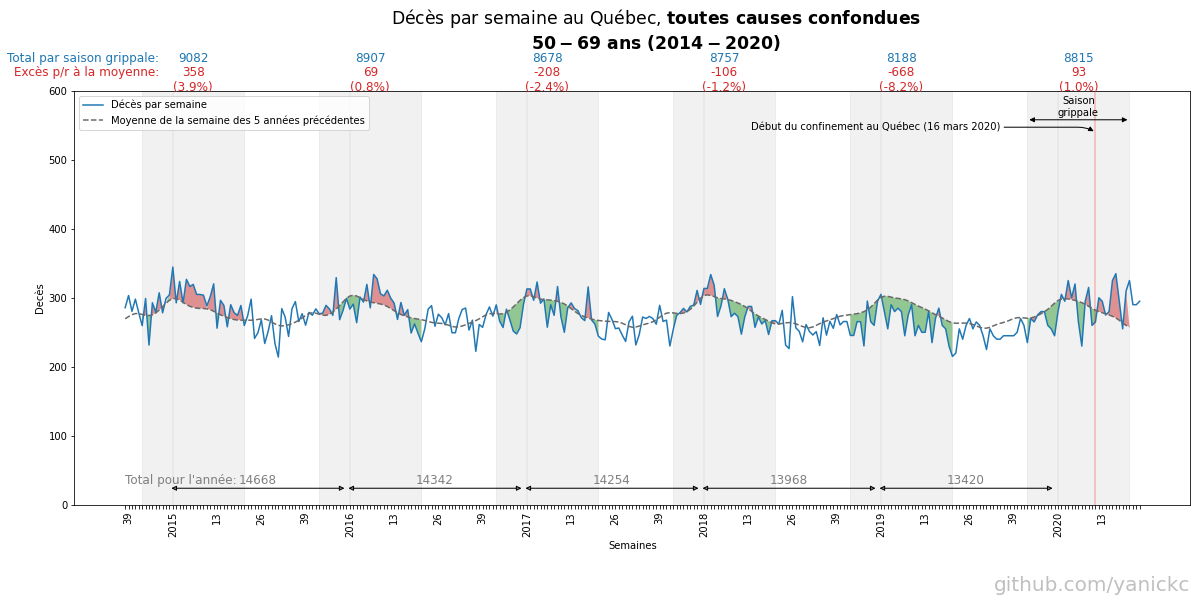

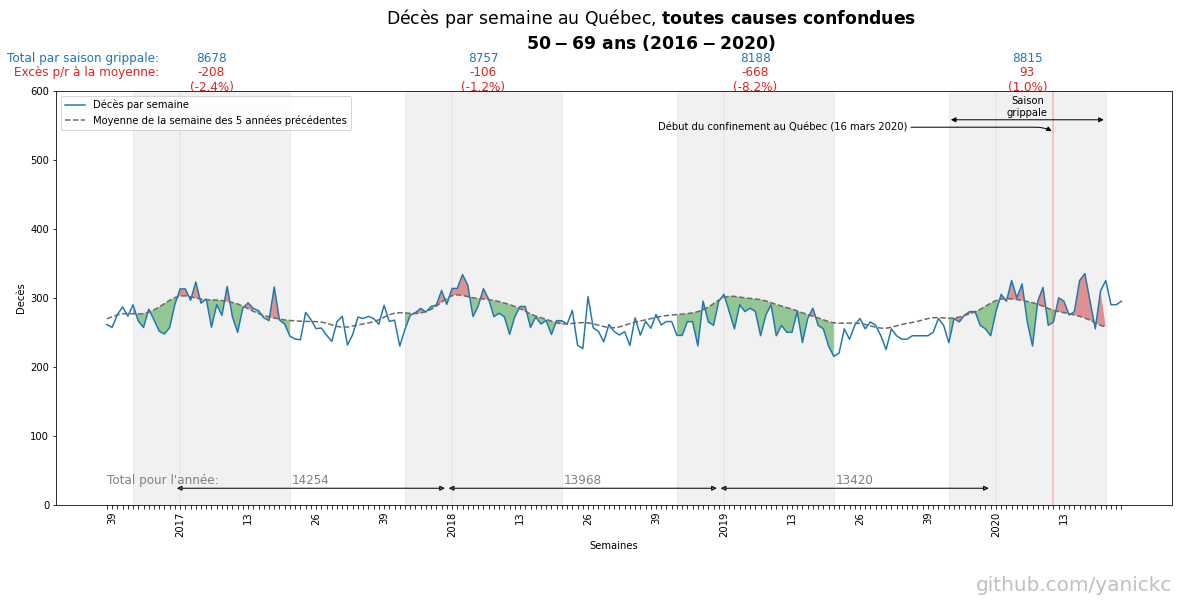

In [16]:
draw_lineplot(df_50_69, "50-69 ans", "deces_norm", "av_norm", "diff_deces_norm", top_y=600, seasons_annotations=False)
draw_lineplot(df_50_69, "50-69 ans", "deces_norm", "av_norm", "diff_deces_norm", top_y=600, start_year=2014, start_month=39, seasons_annotations=False)
draw_lineplot(df_50_69, "50-69 ans", "deces_norm", "av_norm", "diff_deces_norm", top_y=600, start_year=2016, start_month=39, seasons_annotations=False)

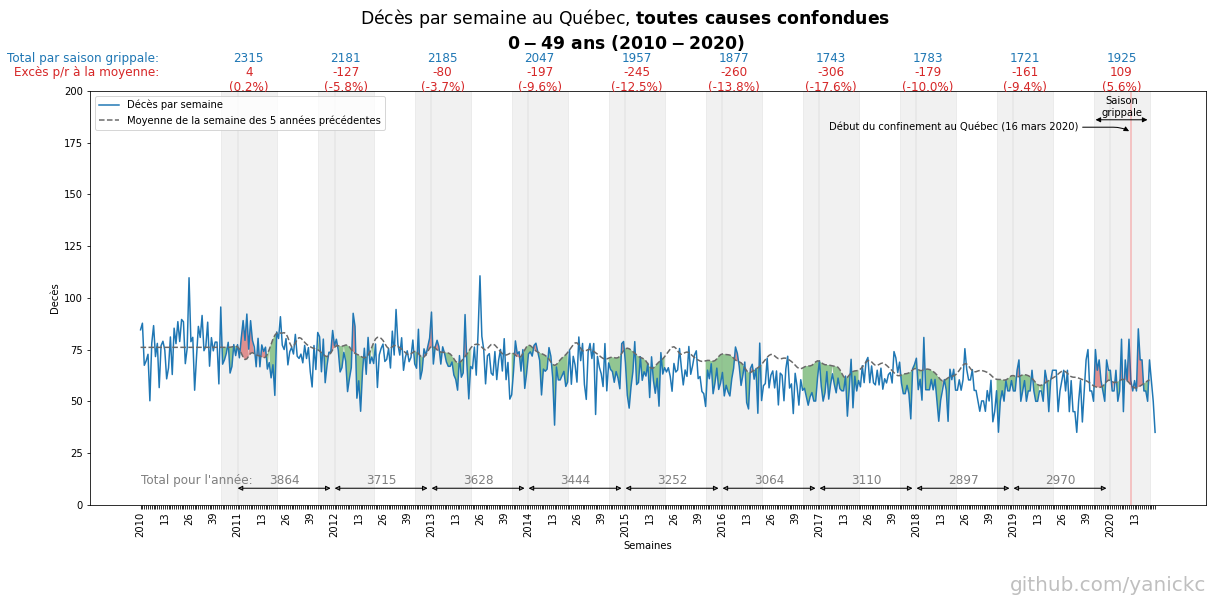

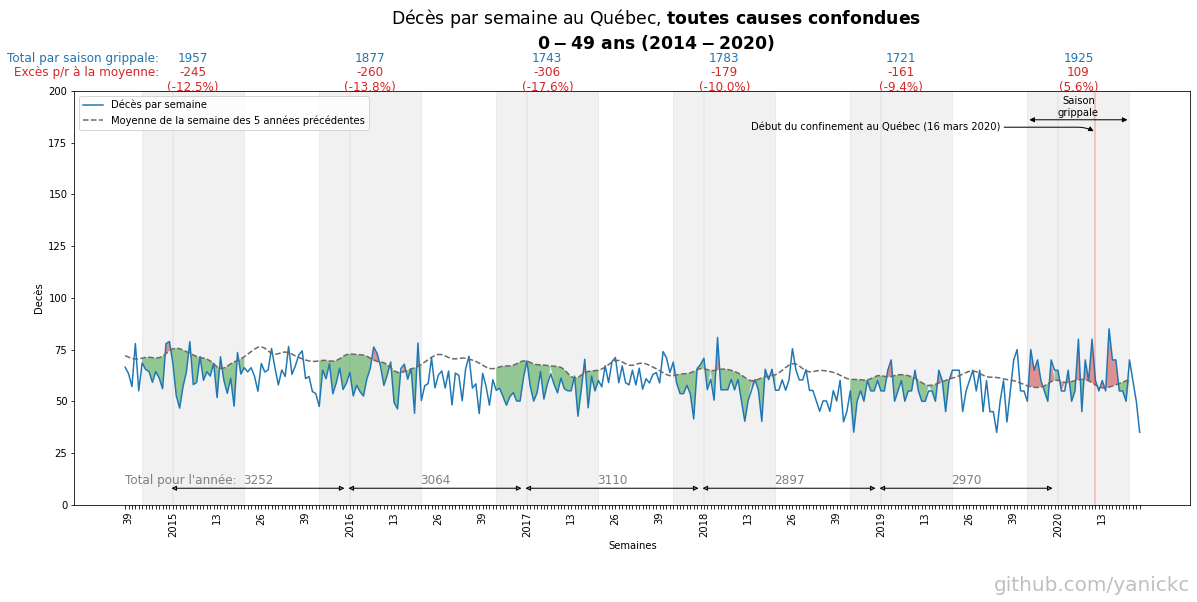

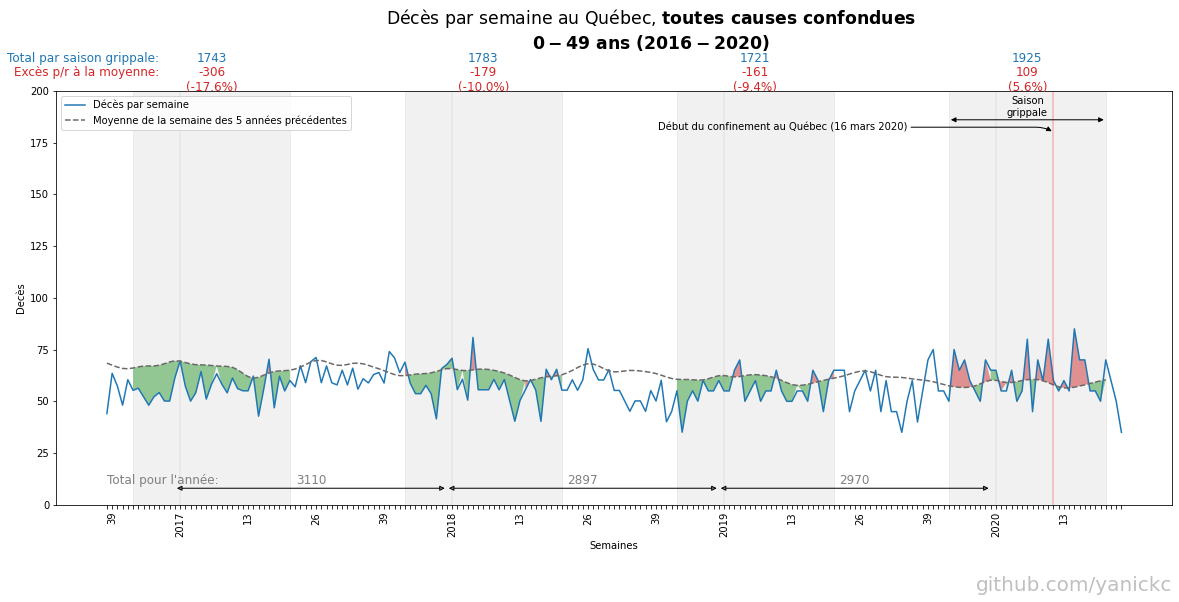

In [17]:
draw_lineplot(df_0_49, "0-49 ans", "deces_norm", "av_norm", "diff_deces_norm", top_y=200, seasons_annotations=False)
draw_lineplot(df_0_49, "0-49 ans", "deces_norm", "av_norm", "diff_deces_norm", top_y=200, start_year=2014, start_month=39, seasons_annotations=False)
draw_lineplot(df_0_49, "0-49 ans", "deces_norm", "av_norm", "diff_deces_norm", top_y=200, start_year=2016, start_month=39, seasons_annotations=False)

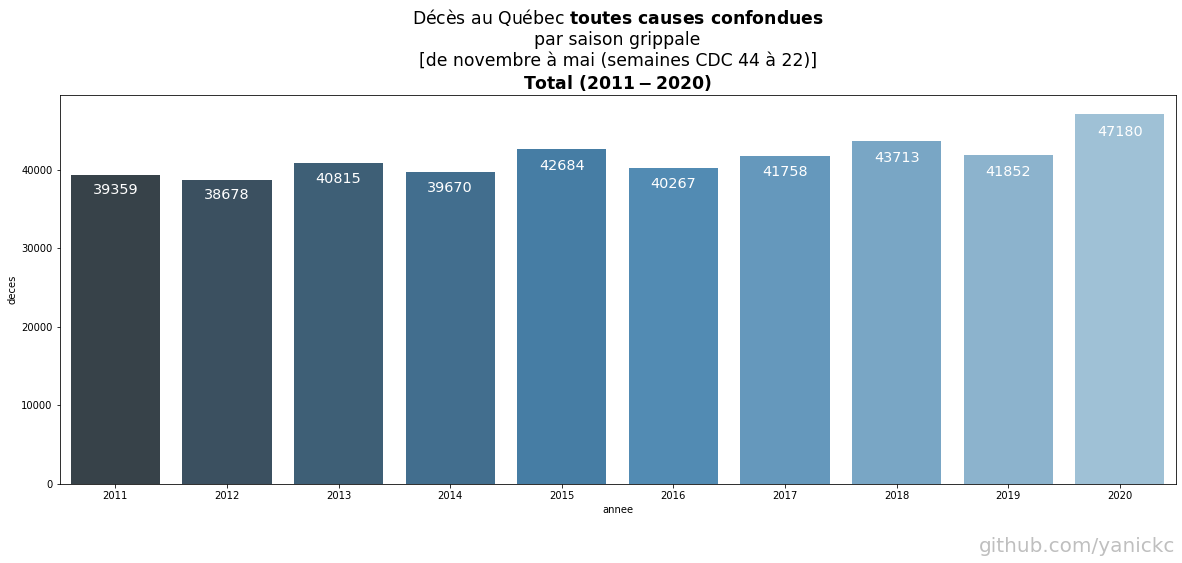

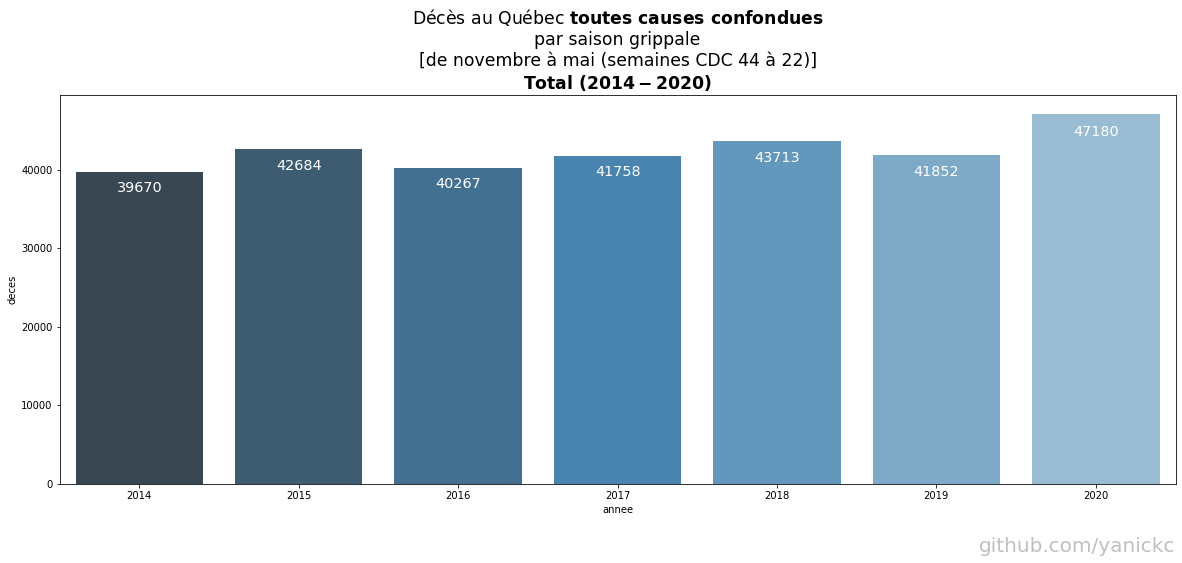

In [18]:
draw_barplot(df_total, "Total")
draw_barplot(df_total, "Total", start_year=2014)

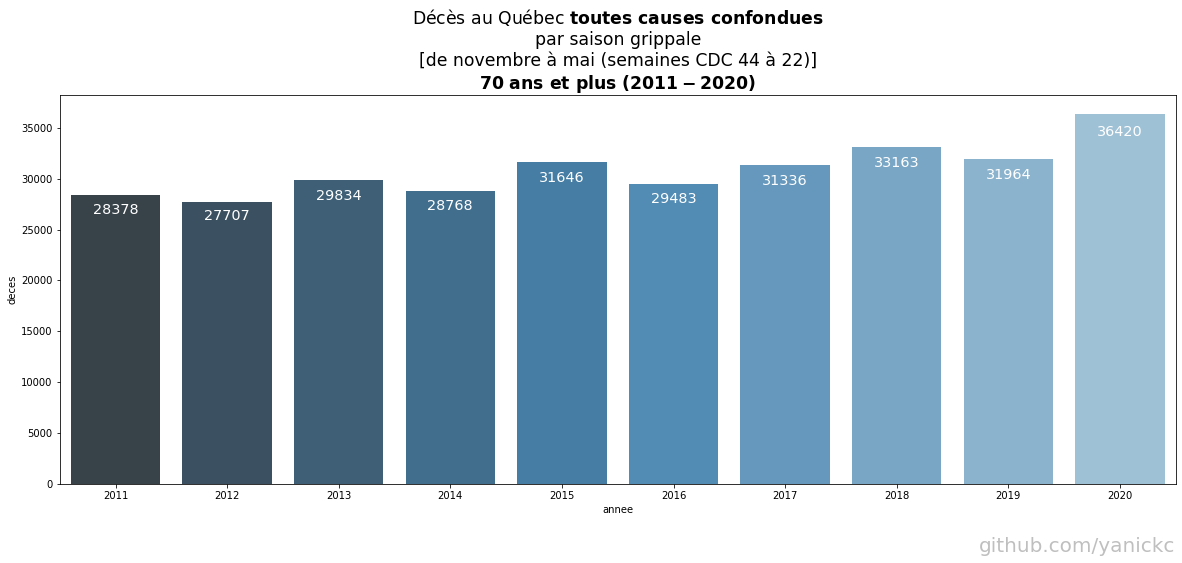

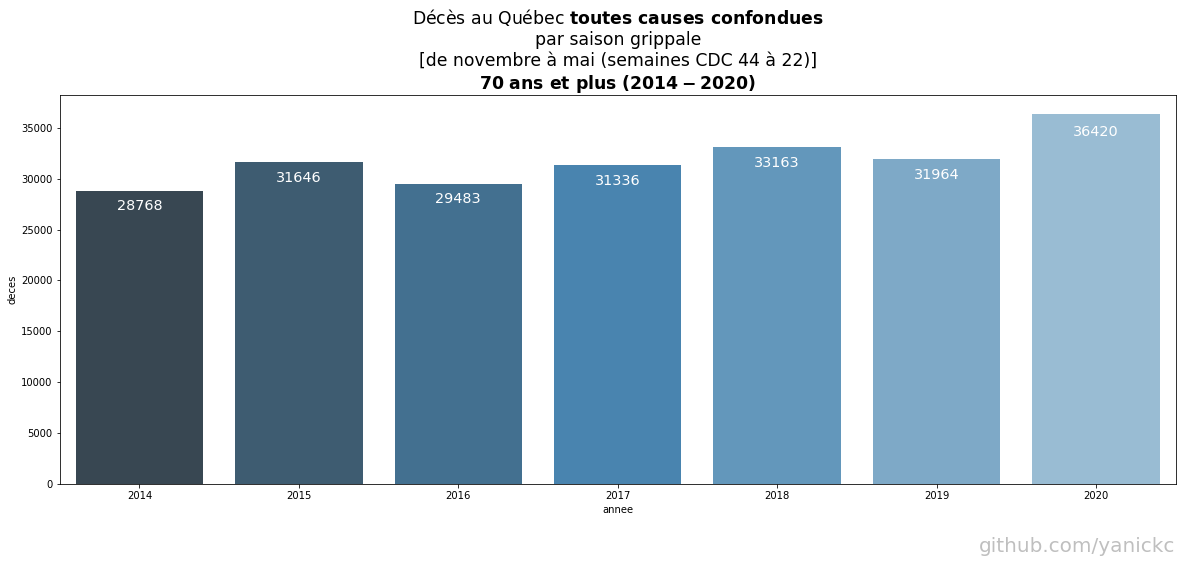

In [19]:
draw_barplot(df_70_plus, "70 ans et plus")
draw_barplot(df_70_plus, "70 ans et plus", start_year=2014)

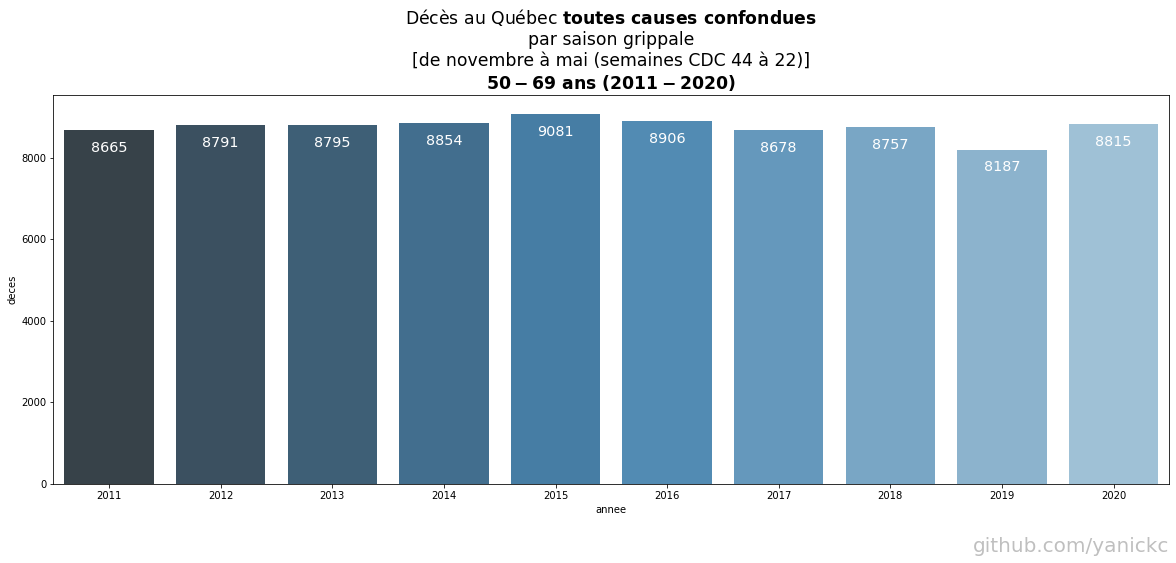

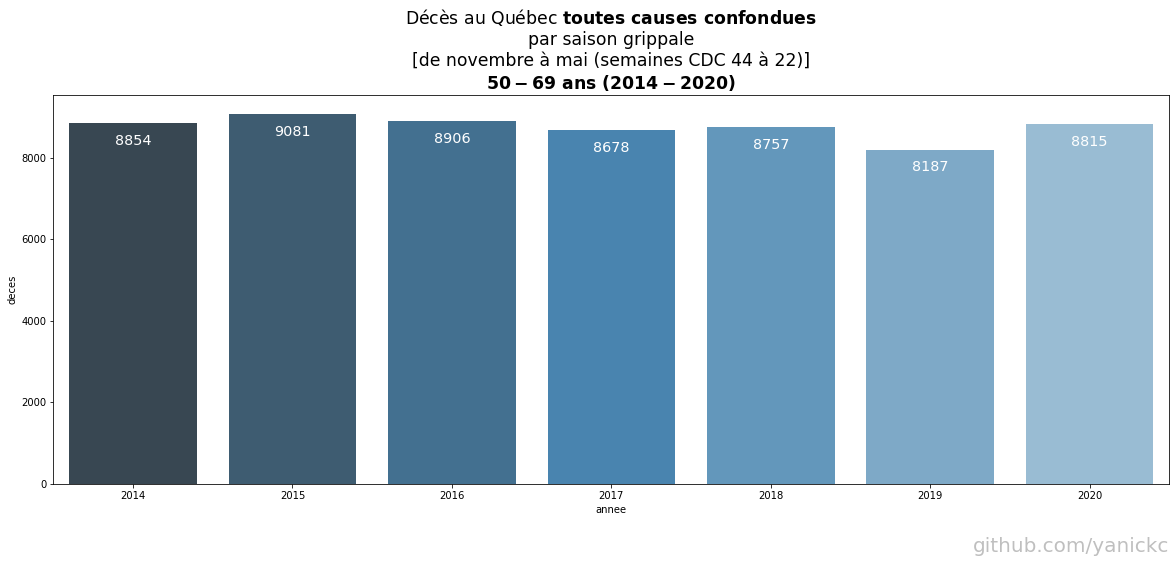

In [20]:
draw_barplot(df_50_69, "50-69 ans")
draw_barplot(df_50_69, "50-69 ans", start_year=2014)

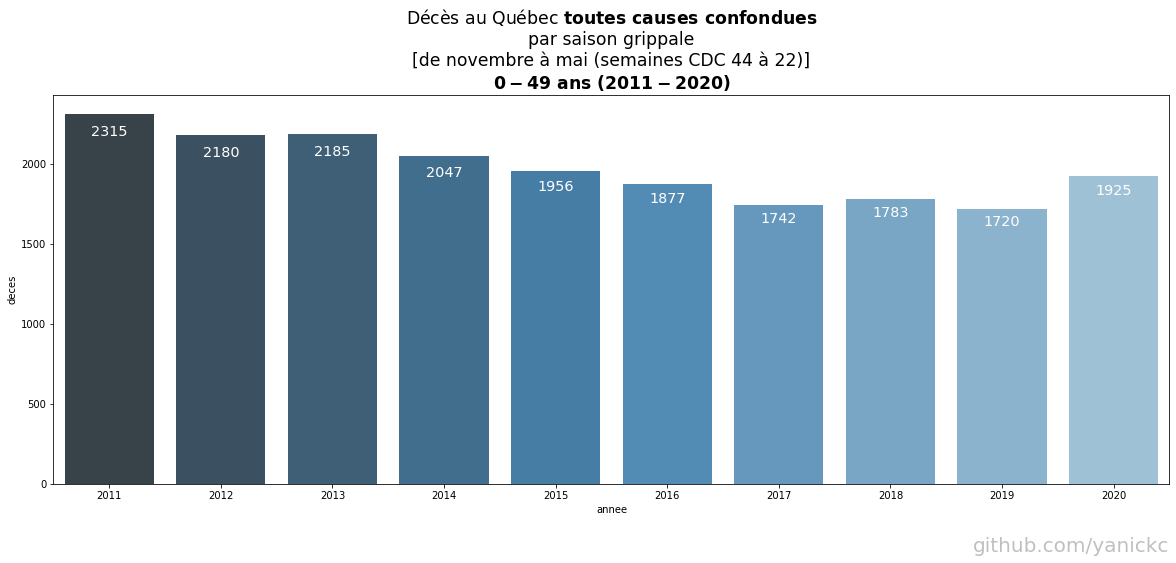

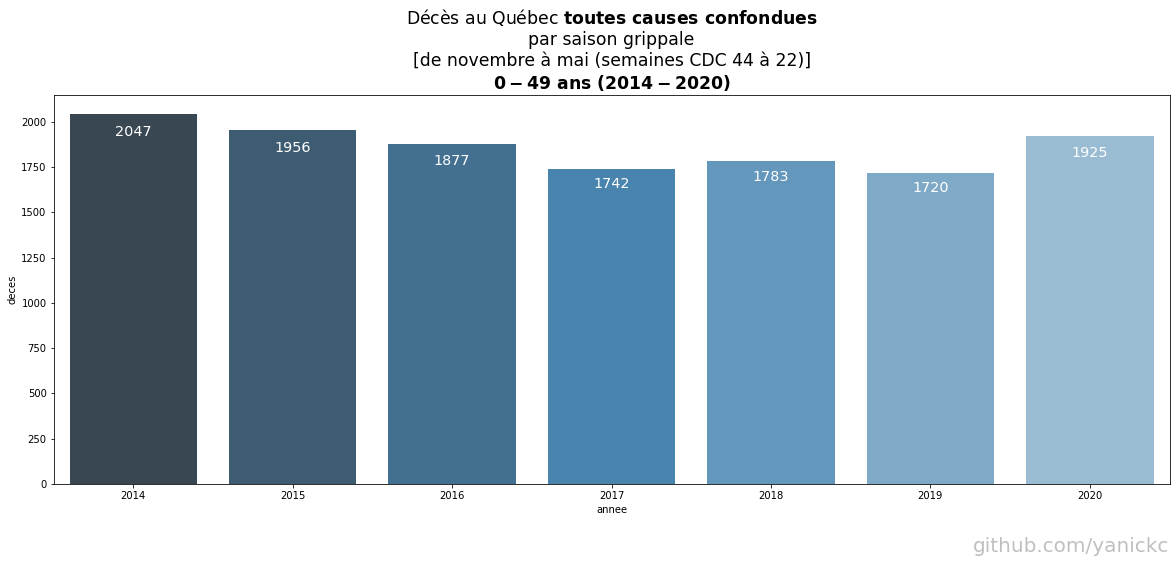

In [21]:
draw_barplot(df_0_49, "0-49 ans")
draw_barplot(df_0_49, "0-49 ans", start_year=2014)